# Introduction to NLP

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bcolz
import re
import itertools
from numpy.random import random, permutation, randn, normal, uniform, choice
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment.

See below to download the dataset.

We will compare to the 2011 ACL [stanford paper](http://ai.stanford.edu/~amaas/data/sentiment/)

In [2]:
data_folder = '/home/lelarge/courses/data/imdb/'
#data_folder = '/home/ubuntu/data/imdb/'
data_imdb = data_folder+'imdb_full.pkl'
data_idx = data_folder+'idx.pkl'

In [3]:
arr = np.array([[1,2,4,5],[4,3,2,0]])

In [4]:
arr[0,:]

array([1, 2, 4, 5])

In [5]:
arr.shape

(2, 4)

In [6]:
embedding_dim = 3
embedding_user = nn.Embedding(6, embedding_dim)
input = Variable(torch.LongTensor([[1,2,4,5],[4,3,2,0]]))
embedding_user(input)

tensor([[[ 0.4564, -1.7849,  1.7414],
         [-0.6956, -0.1206, -0.5653],
         [ 0.0606, -0.5843,  0.0823],
         [ 1.0665, -0.8770,  0.6779]],

        [[ 0.0606, -0.5843,  0.0823],
         [-0.1044,  0.8012,  0.3375],
         [-0.6956, -0.1206, -0.5653],
         [ 0.2030,  0.3286,  2.1310]]])

In [7]:
embedding_user(input).view(2,12)

tensor([[ 0.4564, -1.7849,  1.7414, -0.6956, -0.1206, -0.5653,  0.0606,
         -0.5843,  0.0823,  1.0665, -0.8770,  0.6779],
        [ 0.0606, -0.5843,  0.0823, -0.1044,  0.8012,  0.3375, -0.6956,
         -0.1206, -0.5653,  0.2030,  0.3286,  2.1310]])

In [8]:
embedding_user(input).permute(0,2,1)

tensor([[[ 0.4564, -0.6956,  0.0606,  1.0665],
         [-1.7849, -0.1206, -0.5843, -0.8770],
         [ 1.7414, -0.5653,  0.0823,  0.6779]],

        [[ 0.0606, -0.1044, -0.6956,  0.2030],
         [-0.5843,  0.8012, -0.1206,  0.3286],
         [ 0.0823,  0.3375, -0.5653,  2.1310]]])

In [9]:
#need to be done only once
#!wget -O $data_imdb https://s3.amazonaws.com/text-datasets/imdb_full.pkl

In [10]:
import pickle
f = open(data_imdb,'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [11]:
len(x_train)

25000

In [12]:
g = open(data_idx, 'rb')
idx = pickle.load(g)

This is the word list:

In [13]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

This is the mapping from id to word

In [14]:
idx2word = {v: k for k, v in idx.items()}

Here's the 1st review. As you see, the words have been replaced by ids.

In [15]:
', '.join(map(str, x_train[0]))

'23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215'

The ids can be looked up in idx2word.

In [16]:
idx2word[23022]

'bromwell'

In [17]:
' '.join([idx2word[o] for o in x_train[0]])

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

Reduce vocab size by setting rare words to max index.

In [18]:
vocab_size = 5000

In [19]:
trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_train]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_test]

Look at distribution of lengths of sentences.

In [20]:
lens = np.array(list(map(len, trn)))
(lens.max(), lens.min(), lens.mean())

(2493, 10, 237.71364)

Pad (with zero) or truncate each sentence to make consistent length.

In [21]:
seq_len = 500

trn_pad = np.zeros((len(x_train),seq_len)).astype(np.int32)
test_pad = np.zeros((len(x_test),seq_len)).astype(np.int32)

for idx, s in enumerate(trn):
    trunc = s[-seq_len:]
    trn_pad[idx, -len(trunc):] = trunc

for idx, s in enumerate(test):
    trunc = s[-seq_len:]
    test_pad[idx, -len(trunc):] = trunc

In [22]:
trn_pad[:5,:]

array([[  0,   0,   0, ...,  12,   9, 215],
       [  0,   0,   0, ...,   5, 336, 406],
       [  0,   0,   0, ...,   6, 176, 397],
       [  0,   0,   0, ...,  14,   3, 482],
       [  0,   0,   0, ...,  65, 528,  70]], dtype=int32)

In [23]:
trn_pad.shape

(25000, 500)

In [24]:
test_pad.shape

(25000, 500)

In [25]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: False 


In [26]:
labels_test[:5]

[1, 1, 1, 1, 1]

# Single hidden layer NN

In [90]:
import imp

import NLPModel; imp.reload(NLPModel)
from NLPModel import SentimentModel

model = SentimentModel(embedding_dim = 32, vocab_size = vocab_size, seq_len=seq_len, n_iter = 3)

In [91]:
%%time
model.fit(trn_pad, labels_train, test_pad, labels_test)

312.15625
Epoch 0: train loss 0.4050630355430076 train acc 0.7983535805626598 validation loss 0.32236950837856976 validation acc 0.862204283887468
368.578125
Epoch 1: train loss 0.1528324946627745 train acc 0.9426550511508951 validation loss 0.3356465516835832 validation acc 0.8623721227621484
386.71875
Epoch 2: train loss 0.041446258126379316 train acc 0.9890505115089514 validation loss 0.44531741319105145 validation acc 0.8583919437340154
CPU times: user 6min 20s, sys: 16.3 s, total: 6min 36s
Wall time: 2min 15s


# Single conv layer with max pooling



In [92]:
import nlp_models
from nlp_models import ConvModel

net = ConvModel(embedding_dim = 32, vocab_size = vocab_size,seq_len=seq_len)

model = SentimentModel(net = net,embedding_dim = 32, vocab_size = vocab_size, seq_len=seq_len, n_iter = 3,use_cuda = use_gpu)

In [93]:
%%time
model.fit(trn_pad, labels_train, test_pad, labels_test)

307.43125
Epoch 0: train loss 0.4038330779394225 train acc 0.7862691815856777 validation loss 0.2999089110042433 validation acc 0.871139705882353
361.096875
Epoch 1: train loss 0.1986182473809518 train acc 0.9235214194373402 validation loss 0.2731494004826259 validation acc 0.8880195012787724
372.721875
Epoch 2: train loss 0.12961627653492686 train acc 0.9532528772378517 validation loss 0.3177125509447225 validation acc 0.8813059462915601
CPU times: user 11min 5s, sys: 1min 2s, total: 12min 8s
Wall time: 4min 18s


# GloVe Embedding

[Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) by  Jeffrey Pennington,   Richard Socher,   Christopher D. Manning 

In [100]:
glove_folder = '/home/lelarge/courses/data/glove/'
#glove_folder = '/home/ubuntu/data/glove/'
glove_file = glove_folder + '6B.50d.tgz'

In [32]:
#need to be done only once
#%mkdir -p $glove_folder
#!wget -O $glove_file http://files.fast.ai/models/glove/6B.50d.tgz

In [101]:
import tarfile
tar = tarfile.open(glove_file, "r:gz")
tar.extractall(glove_folder)
tar.close()

In [102]:
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb'), encoding='latin1'),
        pickle.load(open(loc+'_idx.pkl','rb'),encoding='latin1'))

In [103]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [104]:
glove_loc =glove_folder+'6B.50d'
vecs, words, wordidx = load_vectors(glove_loc)

In [105]:
vecs.shape

(400000, 50)

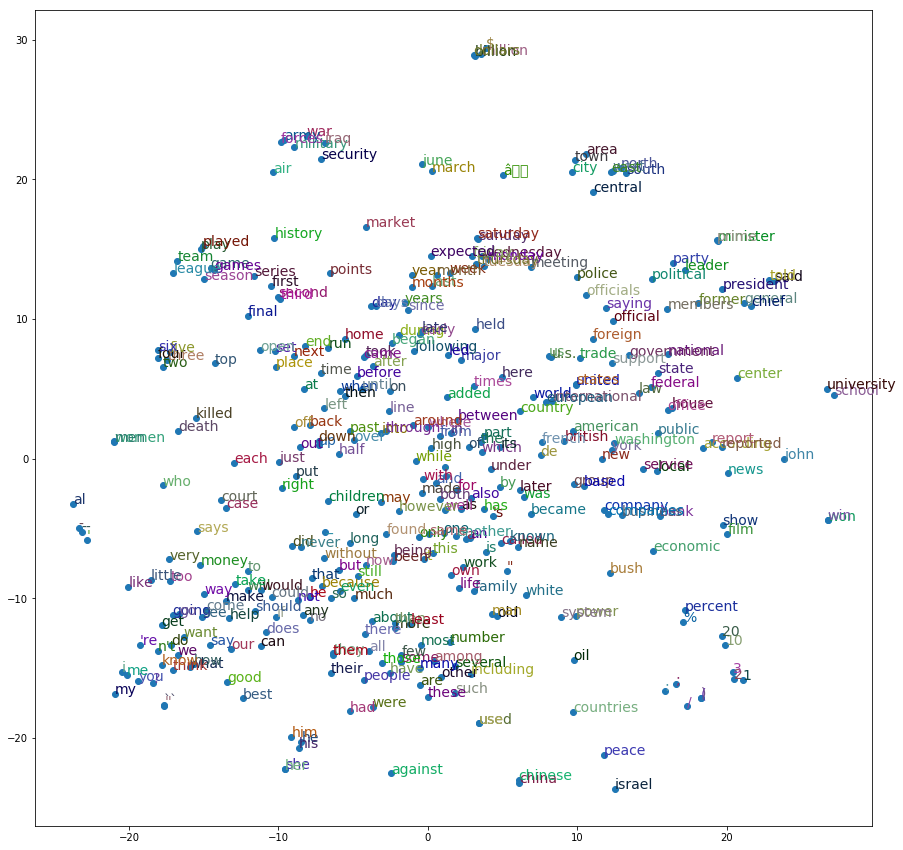

In [106]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(vecs[:500])

start=0; end=350
dat = Y[start:end]
plt.figure(figsize=(15,15))
plt.scatter(dat[:, 0], dat[:, 1])
for label, x, y in zip(words[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=14)
plt.show()

In [107]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [40]:
emb = create_emb()

In [41]:
emb.shape

(5000, 50)

In [42]:
emb[1,:]

array([  1.39333338e-01,   8.32266659e-02,  -1.37473335e-01,
         4.05666654e-02,   1.15090003e-01,  -1.48189999e-02,
        -1.65626665e-01,  -5.95399986e-02,  -2.20076666e-04,
        -2.18866666e-01,   9.28100049e-02,  -4.92233336e-02,
        -1.85590009e-01,   4.88599986e-02,  -3.16983337e-03,
         3.88599994e-03,   3.40133334e-02,  -4.26400006e-02,
        -2.81433324e-01,  -4.06033322e-02,  -5.60033321e-03,
        -1.10929996e-01,  -5.17333349e-02,  -7.71033317e-02,
        -6.39366657e-02,  -6.27433340e-01,  -2.55819996e-01,
         3.30169996e-02,  -1.40416662e-01,  -6.50866677e-02,
         1.33570004e+00,  -6.19799991e-02,  -1.74290001e-01,
        -1.05603337e-01,   1.97376668e-04,   2.48163333e-03,
         5.92600008e-02,  -5.29899995e-02,   4.01366657e-03,
        -1.80743337e-02,  -9.95699962e-02,  -5.24966667e-02,
        -1.15859995e-01,  -1.52123335e-02,  -1.47503336e-01,
         6.26166662e-02,   9.28299967e-04,  -6.13700002e-02,
        -3.83799995e-02,

# More on finetuning with NLP

http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html